In [82]:
import pandas as pd
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_curve, roc_auc_score, precision_recall_curve
from matplotlib import pyplot as plt
import seaborn as sns
import re

In [163]:
train = pd.read_csv('../data/train_nc_nctools-predictions.txt', sep='\t')

In [165]:
train[['#Chrom', 'Ref', 'Alt', 'ReMM_score', 'DeepSEA_Functional_significance_score', 'binarized_label', 'sample_weight']]

,#Chrom,Ref,Alt,ReMM_score,DeepSEA_Functional_significance_score,binarized_label,sample_weight
0,20,ACT,A,NaN,0.000261,1,1.0
1,20,CT,C,NaN,NaN,1,1.0
2,2,C,CC,NaN,0.003451,1,1.0
3,4,GGTGA,G,NaN,0.003184,1,1.0
4,2,GG,G,NaN,0.004027,1,1.0
...,...,...,...,...,...,...,...
81135,1,T,A,0.644,0.055760,0,0.8
81136,17,C,T,0.085,0.078554,0,0.8
81137,2,A,G,0.069,0.052555,0,0.8
81138,22,C,G,0.027,0.118910,0,0.8


In [166]:
train['sample_weight'].value_counts()

0.8    74902
1.0     6238
Name: sample_weight, dtype: int64

<h3>Scaling predictions between 0 - 1</h3>

To easily compare predictions with each other, scale all of them between 0 and 1. 

In [167]:
#Max values
train[['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen-phred', 'Eigen-PC-raw', 'Eigen-PC-phred']].max()

ReMM_score                                1.000000
DeepSEA_Functional_significance_score     0.804400
Eigen-raw                                 3.834147
Eigen-phred                              53.846400
Eigen-PC-raw                             10.676047
Eigen-PC-phred                           50.580700
dtype: float64

In [168]:
#Min values
train[['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw', 'Eigen-phred', 'Eigen-PC-raw', 'Eigen-PC-phred']].min()

ReMM_score                               0.000000
DeepSEA_Functional_significance_score    0.000010
Eigen-raw                               -1.507438
Eigen-phred                              0.000049
Eigen-PC-raw                            -0.360362
Eigen-PC-phred                           0.000128
dtype: float64

In [169]:
scale_min_max = lambda x: (train[x] - train[x].min()) / (train[x].max() - train[x].min())
train['Eigen-raw-scaled'] = scale_min_max('Eigen-raw')
train['Eigen PC-raw-scaled'] = scale_min_max('Eigen-PC-raw')
#train['Eigen-raw-scaled'] = (train['Eigen-raw'] - train['Eigen-raw'].min()) / (train['Eigen-raw'].max() - train['Eigen-raw'].min())

<h3>Plotting</h3>

In [170]:
tools = ['ReMM_score', 'DeepSEA_Functional_significance_score', 'Eigen-raw-scaled', 'Eigen PC-raw-scaled']
df = pd.melt(train[tools + ['label']], id_vars='label', value_vars=tools)
df['Tool'] = df['variable'].apply(lambda x: re.split(r'-|_', x)[0])

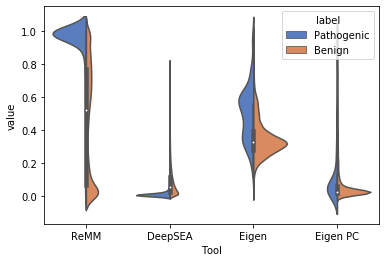

In [171]:
sns.violinplot(x='Tool', y="value", hue='label', data=df, palette="muted", split=True)

<h3>Precision recall curves</h3>

In [231]:
#Drop NA rows for predictions
train_filtered = train.dropna(subset=tools)
train_filtered.label.value_counts()

Benign        59966
Pathogenic      306
Name: label, dtype: int64

In [232]:
#Only use sample weight == 1
train_high_confidence = train_filtered[train_filtered.sample_weight==1]
train_high_confidence.label.value_counts()

Benign        1967
Pathogenic      98
Name: label, dtype: int64

In [174]:
def plot_precision_recall_curve(df):
    pr = {}
    for tool in tools:
        p, r, t = precision_recall_curve(df['binarized_label'], df[tool])
        pr[tool] = {'p': p, 'r': r, 't':t}

    plt.figure(figsize=(9, 5))
    for t in prcurves:
        plt.plot(pr[t]['r'], pr[t]['p'], label='{} (AUC: {})'.format(t, round(auc(pr[t]['r'], pr[t]['p']), 2)))
    plt.legend()

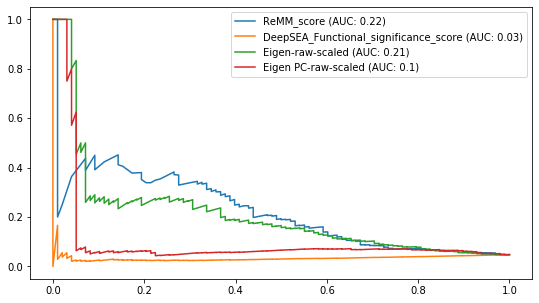

In [175]:
plot_precision_recall_curve(train_high_confidence)

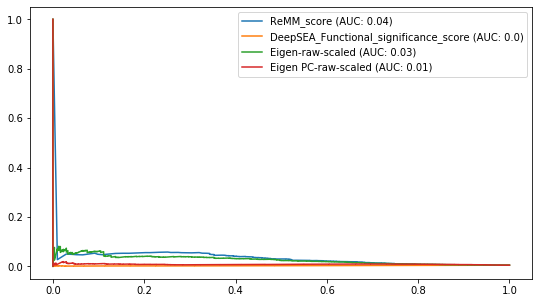

In [177]:
plot_precision_recall_curve(train_filtered)

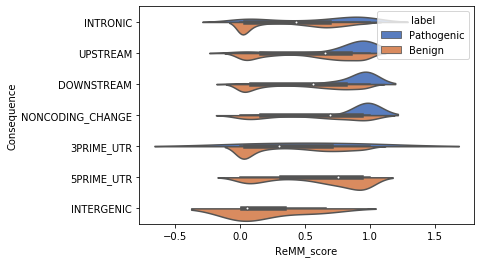

In [234]:
sns.violinplot(x='ReMM_score', y="Consequence", hue='label', data=train_filtered, palette="muted", split=True)

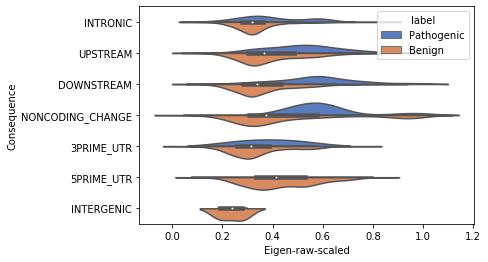

In [235]:
sns.violinplot(x='Eigen-raw-scaled', y="Consequence", hue='label', data=train_filtered, palette="muted", split=True)

In [236]:
#sns.boxplot(x='ReMM_score', y="Consequence", hue='label', data=train_filtered, palette="muted")

Text(0.5, 1.0, 'INTRONIC')

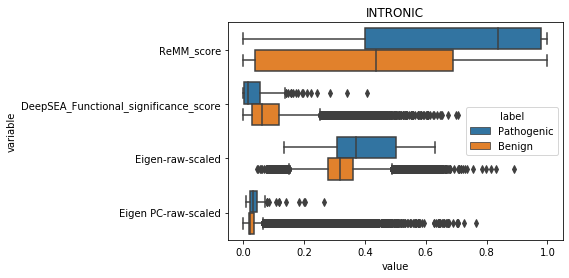

In [237]:
#df = pd.melt(train[tools + ['label']], id_vars='label', value_vars=tools)
sns.boxplot(x='value', y='variable', hue='label', data=pd.melt(train[train.Consequence=='INTRONIC'][tools + ['label']], value_vars=tools, id_vars='label')).set_title('INTRONIC')

Text(0.5, 1.0, 'DOWNSTREAM')

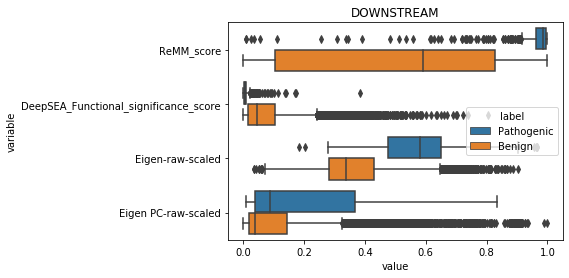

In [238]:
sns.boxplot(x='value', y='variable', hue='label', data=pd.melt(train[train.Consequence=='DOWNSTREAM'][tools + ['label']], value_vars=tools, id_vars='label')).set_title('DOWNSTREAM')

In [178]:
confusion_matrix(train_filtered['binarized_label'], train_filtered['ReMM_score'].apply(lambda x: 1 if x > 0.8 else 0), labels=[1,0])

array([[  203,   103],
       [10827, 49139]])

{'3PRIME_UTR',
 '5PRIME_UTR',
 'DOWNSTREAM',
 'INTERGENIC',
 'INTRONIC',
 'NONCODING_CHANGE',
 'UPSTREAM'}

In [179]:
train.label.value_counts()

Benign        79367
Pathogenic     1773
Name: label, dtype: int64

In [193]:
train_filtered.label.value_counts()

Benign        59966
Pathogenic      306
Name: label, dtype: int64

In [195]:
train_high_confidence.label.value_counts()

Benign        1967
Pathogenic      98
Name: label, dtype: int64

In [200]:
print(train_filtered[train_filtered.label == 'Pathogenic']['Consequence'].value_counts())
print(train_filtered[train_filtered.label == 'Benign']['Consequence'].value_counts())

INTRONIC            115
DOWNSTREAM           91
UPSTREAM             81
NONCODING_CHANGE     17
3PRIME_UTR            2
Name: Consequence, dtype: int64
INTRONIC            32037
DOWNSTREAM          12088
3PRIME_UTR           7160
UPSTREAM             6748
NONCODING_CHANGE      968
5PRIME_UTR            959
INTERGENIC              6
Name: Consequence, dtype: int64


In [202]:
test = pd.read_csv('../data/test_nc.txt', sep='\t')

In [239]:
print(test[test.label == 'Pathogenic']['Consequence'].value_counts())
print(test[test.label == 'Benign']['Consequence'].value_counts())

DOWNSTREAM          109
UPSTREAM             65
INTRONIC             30
NONCODING_CHANGE      7
5PRIME_UTR            4
Name: Consequence, dtype: int64
DOWNSTREAM          109
UPSTREAM             65
INTRONIC             30
NONCODING_CHANGE      7
5PRIME_UTR            4
Name: Consequence, dtype: int64


In [ ]:
#allele frequency
#consequence
